In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Week 2 : Fine-tuning Open Source Embedding Models

> **Prerequisites** : Before running this notebook, make sure that you've completed the previous two notebooks in this week - [1. Synthetic Transactions.ipynb](1. Synthetic Transactions.ipynb) and [2. Finetune Cohere.ipynb](2. Finetune Cohere.ipynb). This notebook will build on top of the previous two notebooks.
> 
> You must have a hugging face token with write access set as an environment variable. If you don't have one, you can create one by following the instructions [here](https://huggingface.co/docs/hub/en/security-tokens).

After exploring managed services, let's dive into fine-tuning open source embedding models. While this approach requires more setup, it offers greater control and potential cost savings.

## Why This Matters

Fine-tuning open source models gives you full control over how your model learns and behaves. While we'll use a small synthetic dataset of 256 examples for this tutorial, real-world applications benefit greatly from larger private datasets - the larger the better. This is because larger datasets allow you to capture specific domain knowledge and relationships that general models might miss.

The main advantage of open source fine-tuning is the cost savings at inference time. Once trained, you can run these models on your own infrastructure without paying per-query fees. This makes them especially attractive for high-volume applications. We'll use sentence-transformers since it offers robust training options, works seamlessly with popular model hubs, and has strong community support.

## What You'll Learn

Though this hands on tutorial, you learn how to

This notebook walks through:

1. **Dataset Preparation**
   - Creating train/test/eval splits
   - Formatting data for triplet loss
   - Setting up evaluation metrics

2. **Model Fine-tuning**
   - Configuring training arguments
   - Setting up loss functions
   - Training and monitoring progress
   
3. **Performance Evaluation**
   - Comparing against base model
   - Measuring recall and MRR improvements
   - Analyzing trade-offs


By the end of this notebook, you'll have a better understanding of when you might want to consider fine-tuning an open source embedding model, how you can do so using the `sentence-transformers` library and how to evaluate the performance of your fine-tuned model.


## Setup

In this section, we'll be fine-tuning the `BAAI/bge-base-en` model. We'll be using the `BatchSemiHardTripletLoss` loss function to train our model. Let's first understand how this loss function works before we dive into the code

### Understanding Semi-Hard Triplet Loss


A Batch Semi Hard Triplet Loss works by taking a batch of sentence pairs and computing the loss for all possible valid triplets, then identifying semi-hard positives and negatives. A semi-hard negative is an example that is not as close to the anchor as the positive example, but is still close to the anchor than the negative example. 
It works with three pieces:

1. An anchor (your main example) - in our case, a transaction description
2. A positive match (something similar) - the correct category
3. A negative match (something different) - incorrect categories that are close, but not quite right

We can see an example of this in the image below where we have an achor, a positive match and a negative match. The negative match is not as close to the anchor as the positive match, but is still close to the anchor than the negative match.

<img src="./data/hard_negatives.png" width="500" alt="Semi-hard negative mining illustration"/>

For our transaction data, this translates to:
- Anchor: Transaction description
- Positive: Correct category
- Negative: Similar but incorrect categories

It's important here to note that the reason why we want an example that's **semi-hard** is because we want to find negative examples that are tricky. They need to be different as compared to the anchor, but not too different. This ultimately helps the model learn to distinguish between similar and dissimilar examples.


<img src = "./data/semi-hard-negative.png" width = 500 />

Using our Cohere dataset format:

1. The transaction description becomes our anchor (query)
2. The correct category is our positive match (relevant_passages)
3. Similar but wrong categories are our negative matches (hard_negatives)

While a single training run can provide a baseline, exploring hyperparameter optimization—through techniques like grid or random search—can significantly enhance model performance, especially when executed on a larger scale with appropriate computational resources. Here's a quick example of [how we can do this using `modal` to run a grid search over all possible parameters](https://modal.com/blog/fine-tuning-embeddings)


### Declaring Constants

When writing fine-tuning code, we want to declare our constants up front. This ensures that we have a consistent set of parameters to use when training our model and makes it easy for us to change them later.

In [4]:
# To resolve the warning from huggingface/tokenizers about parallelism:
# 1. Avoid using `tokenizers` before the fork if possible.
# 2. Explicitly set the environment variable TOKENIZERS_PARALLELISM to either 'true' or 'false'.
import os

# Set the environment variable to disable parallelism warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

TEST_SIZE = 0.2
BASE_MODEL_NAME = "BAAI/bge-base-en"
FINETUNED_MODEL_NAME = "ivanleomk/finetuned-bge-base-en"

MODEL_OUTPUT_DIR = "./models/bge-base-en"
CATEGORIES_PATH = "data/categories.json"
TRAIN_EVALUATOR_NAME = "bge-base-en-train"
EVAL_EVALUATOR_NAME = "bge-base-en-eval"


### Preparing the Dataset

While we use the same dataset as before, we need to handle a lot more configuration when fine-tuning open source models in order for us to evaluate our model's performance while training as well as to use the `BatchSemiHardTripletLoss` loss function.

To do so, we'll format our original train and eval split into a train, test and eval split. 

- Train : This is only used to train the model
- Test : This is used to evaluate the model during training
- Eval : This is used to evaluate the model after training

We want to have a separate set of data points set aside for testing our model during training or to use when evaluating different versions of our model. This ensures that our model does not overfit to the evaluation dataset.

In [8]:
from braintrust import init_dataset
import json

categories = json.load(open(CATEGORIES_PATH))
dataset = init_dataset(project="fine-tuning", name="Synthetic Transactions")


def get_dataset_split(split: str, dataset):
    return [
        {
            "input": transaction["input"],
            "expected": transaction["expected"],
        }
        for transaction in dataset
        if transaction["metadata"]["split"] == split
    ]


train_data = get_dataset_split("train", dataset)
eval_data = get_dataset_split("eval", dataset)
test_data = train_data[: int(len(train_data) * TEST_SIZE)]
train_data = train_data[int(len(train_data) * TEST_SIZE) :]

In [21]:
from collections import defaultdict
import random
from datasets import Dataset


def create_labels(data):
    label_to_example = defaultdict(list)

    for item in data:
        label_to_example[item["expected"][0]].append(item)

    return {label: idx for idx, label in enumerate(label_to_example.keys())}


def create_sentence_to_label_dataset(data, label_to_idx):
    return Dataset.from_dict(
        {
            "sentence": [item["input"] for item in data],
            "label": [label_to_idx[item["expected"][0]] for item in data],
        }
    )


def create_triplet_dataset(data):
    label_to_example = defaultdict(list)

    for item in data:
        label_to_example[item["expected"][0]].append(item)

    labels = set(label_to_example.keys())

    anchors = []
    positives = []
    negatives = []

    for item in data:
        label = item["expected"][0]
        anchor = item
        positive = label
        negative = random.choice([item for item in labels if item != label])
        anchors.append(anchor)
        positives.append(positive)
        negatives.append(negative)

    return {"anchor": anchors, "positive": positives, "negative": negatives}


labels_to_idx = create_labels(train_data)

train_triplets = create_triplet_dataset(train_data)
test_triplets = create_triplet_dataset(test_data)
eval_triplets = create_triplet_dataset(eval_data)

sentence_to_label_train_dataset = create_sentence_to_label_dataset(
    train_data, labels_to_idx
)
sentence_to_label_test_dataset = create_sentence_to_label_dataset(
    test_data, labels_to_idx
)
sentence_to_label_eval_dataset = create_sentence_to_label_dataset(
    eval_data, labels_to_idx
)


### Fine-Tuning

Now that we have our training data formatted in the right format, we can start training our model. We'll do so in 3 steps

1. First we'll declare training arguments - we're using the default arguments provided in their documentation but ideally you'd want to experiment and tinkker with different configurations

2. Next we'll start a training run. We're using the `wandb` integration here to log our training run to Weights & Biases. You'll need to create a Weights & Biases account and authenticate with `wandb login`

3. Finally, we'll train our model before uploading it to the Hugging Face model hub.

In [5]:
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
)
from sentence_transformers.losses import BatchSemiHardTripletLoss
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import TripletEvaluator

model = SentenceTransformer(BASE_MODEL_NAME)
loss = BatchSemiHardTripletLoss(model)
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir=MODEL_OUTPUT_DIR,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    fp16=False,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=100,
)

train_evaluator = TripletEvaluator(
    anchors=train_triplets["anchor"],
    positives=train_triplets["positive"],
    negatives=train_triplets["negative"],
    name=TRAIN_EVALUATOR_NAME,
)

train_evaluator(model)

{'bge-base-en-train_cosine_accuracy': 0.8269230769230769,
 'bge-base-en-train_dot_accuracy': 0.17307692307692307,
 'bge-base-en-train_manhattan_accuracy': 0.8173076923076923,
 'bge-base-en-train_euclidean_accuracy': 0.8269230769230769,
 'bge-base-en-train_max_accuracy': 0.8269230769230769}

In [23]:
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=sentence_to_label_train_dataset,
    eval_dataset=sentence_to_label_test_dataset,
    loss=loss,
    evaluator=train_evaluator,
)

trainer.train()

  0%|          | 0/65 [00:00<?, ?it/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

{'train_runtime': 7.9645, 'train_samples_per_second': 130.58, 'train_steps_per_second': 8.161, 'train_loss': 4.90084463266226, 'epoch': 5.0}


TrainOutput(global_step=65, training_loss=4.90084463266226, metrics={'train_runtime': 7.9645, 'train_samples_per_second': 130.58, 'train_steps_per_second': 8.161, 'total_flos': 0.0, 'train_loss': 4.90084463266226, 'epoch': 5.0})

In [24]:
test_evaluator = TripletEvaluator(
    anchors=eval_triplets["anchor"],
    positives=eval_triplets["positive"],
    negatives=eval_triplets["negative"],
    name=EVAL_EVALUATOR_NAME,
)
test_evaluator(model)

{'bge-base-en-eval_cosine_accuracy': 0.9393939393939394,
 'bge-base-en-eval_dot_accuracy': 0.06060606060606061,
 'bge-base-en-eval_manhattan_accuracy': 0.9393939393939394,
 'bge-base-en-eval_euclidean_accuracy': 0.9393939393939394,
 'bge-base-en-eval_max_accuracy': 0.9393939393939394}

In [25]:
model.save_pretrained(f"models/finetuned-{BASE_MODEL_NAME}")
model.push_to_hub(FINETUNED_MODEL_NAME, exist_ok=True)


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

'https://huggingface.co/ivanleomk/finetuned-bge-base-en/commit/3abaa388fc4aa26f87d831b3ea787703a1681ca6'

## Evaluation

> **Note** : If you haven't had your braintrust free tier bumped yet, we've implemented a version below that uses the ThreadPoolExecutor to parallelize the evaluation process instead. Scroll down a bit more to see it.

Here we use `lancedb` again to evaluate our model. It comes with out of the box support for hugging face models, which makkes it incredibly easy for us to evaluate our fine-tuned model vs the base model. 

We'll similarly use `braintrust` to evaluate our model and compare it against the base model by looking at recall and mrr @1,3,5.

In [6]:
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry
import json

def create_lancedb_table(model_name: str, categories: list[str]):
    model = get_registry().get("huggingface").create(name=model_name)


    class Category(LanceModel):
        text: str = model.SourceField()
        embedding: Vector(model.ndims()) = model.VectorField()


    db = lancedb.connect("./lancedb")
    table_name = f"categories-{model_name.replace('/', '-')}"
    if table_name in db.table_names():
        table = db.open_table(table_name)
    else:
        table = db.create_table(
            table_name, schema=Category, mode="overwrite"
        )
        table.add(
            [
                {
                    "text": category["category"],
                }
                for category in categories
            ]
        )

    return table

In [9]:

from braintrust import Score, Eval
from helpers import get_metrics_at_k, task
import json

categories = json.load(open(CATEGORIES_PATH))
base_table = create_lancedb_table(BASE_MODEL_NAME, categories)
finetuned_table = create_lancedb_table(FINETUNED_MODEL_NAME, categories)

db = lancedb.connect("./lancedb")


def evaluate_braintrust(input, output, **kwargs):
    metrics = get_metrics_at_k(metrics=["mrr", "recall"], sizes=[1, 3, 5])
    return [
        Score(
            name=metric,
            score=score_fn(output, kwargs["expected"]),
            metadata={"query": input, "result": output, **kwargs["metadata"]},
        )
        for metric, score_fn in metrics.items()
    ]

results = []
for query_table in [base_table, finetuned_table]:
    results.append(
        await Eval(
        "fine-tuning",
        experiment_name=f"synthetic-transactions-train-{query_table.name}",
        data=lambda: eval_data,
        task=lambda query: task(user_query=query, table=query_table, reranker=None, max_k=25),
        scores=[evaluate_braintrust],
        metadata={"model": query_table.name},
    )
    )


Experiment synthetic-transactions-train-categories-BAAI-bge-base-en-0e21f37e is running at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/synthetic-transactions-train-categories-BAAI-bge-base-en-0e21f37e
fine-tuning [experiment_name=synthetic-transactions-train-categories-BAAI-bge-base-en] (data): 66it [00:00, 7679.96it/s]


fine-tuning [experiment_name=synthetic-transactions-train-categories-BAAI-bge-base-en] (tasks):   0%|         …


=========================SUMMARY=========================
synthetic-transactions-train-categories-BAAI-bge-base-en-0e21f37e compared to synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en-test:
39.39% (-18.18%) 'mrr@1'    score	(5 improvements, 17 regressions)
53.28% (-17.93%) 'mrr@3'    score	(6 improvements, 26 regressions)
54.27% (-18.31%) 'mrr@5'    score	(6 improvements, 29 regressions)
39.39% (-18.18%) 'recall@1' score	(5 improvements, 17 regressions)
71.21% (-15.15%) 'recall@3' score	(1 improvements, 11 regressions)
75.76% (-16.67%) 'recall@5' score	(0 improvements, 11 regressions)

1739747903.70s start
1739747904.89s end
0.85s (-46.46%) 'duration'	(66 improvements, 0 regressions)

See results for synthetic-transactions-train-categories-BAAI-bge-base-en-0e21f37e at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/synthetic-transactions-train-categories-BAAI-bge-base-en-0e21f37e


Experiment synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en-0d7d8650 is running at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en-0d7d8650
fine-tuning [experiment_name=synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en] (data): 66it [00:00, 43396.15it/s]


fine-tuning [experiment_name=synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en] (tasks):…


=========================SUMMARY=========================
synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en-0d7d8650 compared to synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en-test:
54.55% (-03.03%) 'mrr@1'    score	(1 improvements, 3 regressions)
69.44% (-01.77%) 'mrr@3'    score	(2 improvements, 5 regressions)
70.20% (-02.37%) 'mrr@5'    score	(2 improvements, 7 regressions)
54.55% (-03.03%) 'recall@1' score	(1 improvements, 3 regressions)
86.36% (-) 'recall@3' score	(0 improvements, 0 regressions)
89.39% (-03.03%) 'recall@5' score	(0 improvements, 2 regressions)

1739747908.17s start
1739747911.53s end
3.03s (+170.91%) 'duration'	(0 improvements, 66 regressions)

See results for synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en-0d7d8650 at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en-0d7d8650


In [28]:
import pandas as pd
scores = []

for result in results:
    result_scores = {}
    for score_name, score in result.summary.scores.items():
        result_scores[score_name] = score.score
    scores.append(result_scores)

df = pd.DataFrame(scores,index=["Base Model", "Fine-Tuned Model"])
df.round(2)

,mrr@1,mrr@3,mrr@5,recall@1,recall@3,recall@5
Base Model,0.39,0.53,0.54,0.39,0.71,0.76
Fine-Tuned Model,0.55,0.69,0.70,0.55,0.86,0.89


In [10]:
from concurrent.futures import ThreadPoolExecutor
from helpers import task, get_metrics_at_k
import pandas as pd

metrics = get_metrics_at_k(metrics=["mrr", "recall"], sizes=[1, 3, 5])

def evaluate_query(output, expense_category):
    scores = {}
    for metric, score_fn in metrics.items():
        scores[metric] = score_fn(output, expense_category)
    return scores

results = {}

with ThreadPoolExecutor(max_workers=10) as executor:
    for table in [base_table, finetuned_table]:
        query_results = list(
            executor.map(
                lambda q: task(
                    user_query=q["input"], 
                    table=table,
                    reranker=None,
                    max_k=25
                ),
                eval_data,
            )
        )
        scores = [
            evaluate_query(output, transaction["expected"]) 
            for output, transaction in zip(query_results, eval_data)
        ]
        df = pd.DataFrame(scores)
        results[table.name] = round(pd.DataFrame(scores).mean(), 4)
        print(results[table.name])


mrr@1       0.3939
mrr@3       0.5328
mrr@5       0.5427
recall@1    0.3939
recall@3    0.7121
recall@5    0.7576
dtype: float64
mrr@1       0.5455
mrr@3       0.6944
mrr@5       0.7020
recall@1    0.5455
recall@3    0.8636
recall@5    0.8939
dtype: float64


In [11]:

df = pd.DataFrame(results.values(), index=["Base Model", "Fine-Tuned Model"])
df.round(2)

,mrr@1,mrr@3,mrr@5,recall@1,recall@3,recall@5
Base Model,0.39,0.53,0.54,0.39,0.71,0.76
Fine-Tuned Model,0.55,0.69,0.70,0.55,0.86,0.89


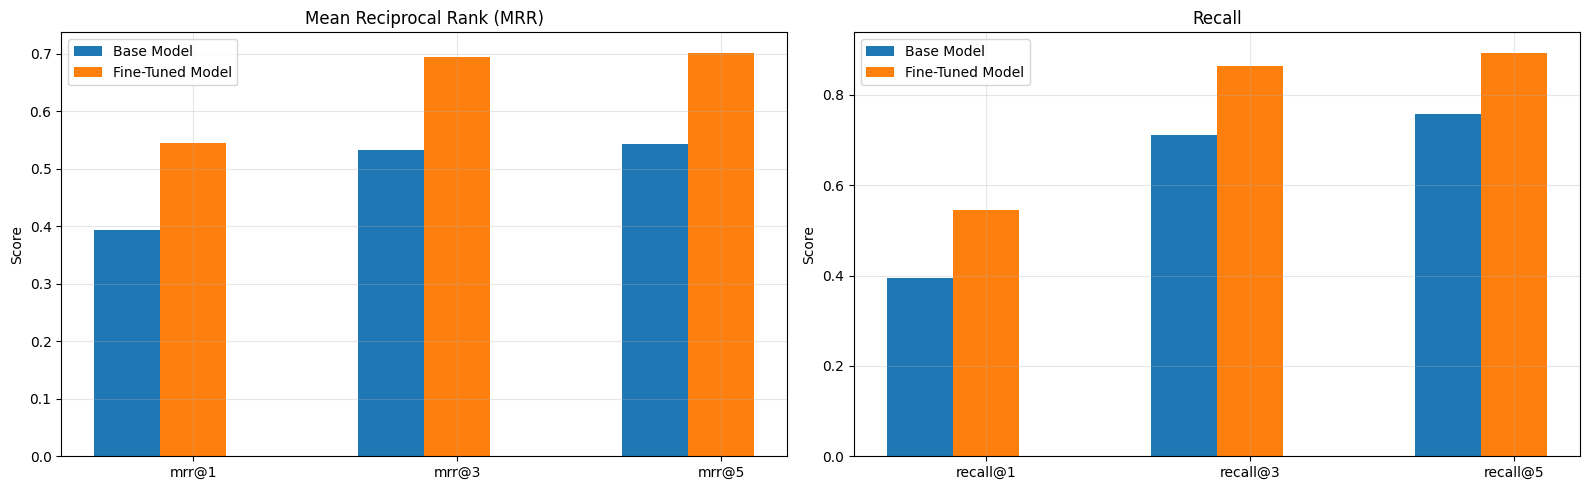

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot MRR scores
mrr_cols = ['mrr@1', 'mrr@3', 'mrr@5']
x = np.arange(len(mrr_cols))
width = 0.25

for i, model in enumerate(df.index):
    offset = (i - 1) * width
    ax1.bar(x + offset, df.loc[model, mrr_cols], width, label=model)

ax1.set_title('Mean Reciprocal Rank (MRR)')
ax1.set_xticks(x)
ax1.set_xticklabels(mrr_cols)
ax1.set_ylabel('Score')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot Recall scores
recall_cols = ['recall@1', 'recall@3', 'recall@5']
x = np.arange(len(recall_cols))

for i, model in enumerate(df.index):
    offset = (i - 1) * width
    ax2.bar(x + offset, df.loc[model, recall_cols], width, label=model)

ax2.set_title('Recall')
ax2.set_xticks(x)
ax2.set_xticklabels(recall_cols)
ax2.set_ylabel('Score')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Conclusion

In this notebook, we successfully fine-tuned the BAAI/bge-base-en model using sentence-transformers, achieving a 20% improvement in MRR@1 and a 12% increase in recall@5 compared to the base model. More importantly, we learned how to balance performance gains against implementation complexity.

This concludes our exploration of fine-tuning approaches, where we:

1. Created synthetic training data thoughtfully using iterative generation and manual review to ensure quality
2. Explored managed re-rankers through Cohere, showing how they offer quick wins with minimal setup
3. Implemented open-source fine-tuning using sentence-transformers, trading simplicity for greater control and lower inference costs

While managed solutions like Cohere offer faster time-to-production and simplified deployment, open-source models provide greater control and customization potential. The choice between these approaches should be guided by your specific requirements, resources, and the level of performance improvement needed for your use case. 

These retrieval improvements complement the techniques we'll explore in later weeks - like discovering query patterns (Week 4) and handling structured data (Week 5). By combining effective retrieval with these methods, we can build more robust and capable RAG systems.